In [1]:
from IPython.display import clear_output
import sys
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from util.qtable_helper import record_video_qtable, evaluate_qtable_policy
from util.notebook import display_videos_from_path

In [2]:
# Configuração do ambiente
ENV_NAME = "FrozenLake-v1"
env = gym.make(ENV_NAME, is_slippery=True, render_mode="rgb_array")

In [3]:
# Hiperparâmetros ajustados
GAMMA = 0.99  # Fator de desconto
LEARNING_RATE = 1e-3  # Taxa de aprendizado
BATCH_SIZE = 128  # Tamanho do batch
ITERATIONS = 5000  # Número de iterações
EPSILON_START = 1.0  # Valor inicial de ε (exploração)
EPSILON_END = 0.1  # Valor mínimo de ε
EPSILON_DECAY = 0.995  # Taxa de decaimento de ε

In [4]:
# Rede Neural para Aproximação da Função Q
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Inicializar a rede neural
input_dim = env.observation_space.n  
output_dim = env.action_space.n      
q_network = QNetwork(input_dim, output_dim)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Função para converter estados em tensores one-hot
def to_one_hot(state, num_states):
    one_hot = np.zeros(num_states)
    one_hot[state] = 1
    return torch.FloatTensor(one_hot)

In [5]:
# Carregar o replay buffer salvo
replay_buffer = np.load('dataSet/DataSet_FrozenLake.npy', allow_pickle=True)
print("Replay buffer carregado com sucesso! Tamanho:", len(replay_buffer))

Replay buffer carregado com sucesso! Tamanho: 2


In [6]:
# Extrair as transições do dataset SARSA
env_obj, transitions = replay_buffer

# Reformatar as transições para o formato esperado
formatted_transitions = []
for transition in transitions:
    state, action, reward, next_state, done = transition
    formatted_transitions.append((state, action, reward, next_state, done))

replay_buffer = formatted_transitions
print(f"Transições formatadas: {len(replay_buffer)}")

Transições formatadas: 264354


In [7]:
# Função para avaliar a política
def evaluate_policy(env, policy, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = policy[state]
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

# Função para extrair a política a partir da rede neural com ruído aleatório
def extract_policy(q_network, num_states, epsilon=0.1):
    policy = []
    for state in range(num_states):
        state_tensor = to_one_hot(state, num_states).unsqueeze(0)
        q_values = q_network(state_tensor).detach().numpy()
        
        # Introduzir ruído aleatório para evitar ciclos repetitivos
        if np.random.rand() < epsilon:
            action = np.random.choice(len(q_values[0]))  # Escolha aleatória de ação
        else:
            action = np.argmax(q_values)  # Melhor ação com base nos valores Q
        
        policy.append(action)
    return policy

In [8]:
# Listas para armazenar métricas
losses = []
success_rates = []
q_values_means = []
rewards_variances = []

# Treinamento com Fitted Q-Iteration (FQI)
epsilon = EPSILON_START
for iteration in range(ITERATIONS):
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.stack([to_one_hot(s, input_dim) for s in states])
    next_states = torch.stack([to_one_hot(ns, input_dim) for ns in next_states])
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    current_q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

    with torch.no_grad():
        next_q_values = q_network(next_states).max(1)[0]
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Atualização da rede neural para evitar comportamento repetitivo
    loss = criterion(current_q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    q_values_means.append(current_q_values.mean().item())
    rewards_variances.append(torch.var(rewards).item())

    if iteration % 25 == 0:
        policy = extract_policy(q_network, input_dim, epsilon)
        success_rate = evaluate_policy(env, policy, episodes=500)
        losses.append(loss.item())
        success_rates.append(success_rate)
        print(f"Iteração {iteration}, Perda: {loss.item():.4f}, Recompensa Média: {success_rate:.2f}, Epsilon: {epsilon:.4f}")

Iteração 0, Perda: 0.0021, Recompensa Média: 0.03, Epsilon: 0.9950
Iteração 25, Perda: 0.0297, Recompensa Média: 0.00, Epsilon: 0.8778
Iteração 50, Perda: 0.0079, Recompensa Média: 0.00, Epsilon: 0.7744
Iteração 75, Perda: 0.0141, Recompensa Média: 0.00, Epsilon: 0.6832
Iteração 100, Perda: 0.0071, Recompensa Média: 0.07, Epsilon: 0.6027
Iteração 125, Perda: 0.0043, Recompensa Média: 0.00, Epsilon: 0.5318
Iteração 150, Perda: 0.0035, Recompensa Média: 0.21, Epsilon: 0.4691
Iteração 175, Perda: 0.0084, Recompensa Média: 0.00, Epsilon: 0.4139
Iteração 200, Perda: 0.0062, Recompensa Média: 0.71, Epsilon: 0.3651
Iteração 225, Perda: 0.0125, Recompensa Média: 0.61, Epsilon: 0.3221
Iteração 250, Perda: 0.0074, Recompensa Média: 0.25, Epsilon: 0.2842
Iteração 275, Perda: 0.0094, Recompensa Média: 0.40, Epsilon: 0.2507
Iteração 300, Perda: 0.0055, Recompensa Média: 0.00, Epsilon: 0.2212
Iteração 325, Perda: 0.0143, Recompensa Média: 0.72, Epsilon: 0.1951
Iteração 350, Perda: 0.0103, Recompensa

In [9]:
# Salvar o modelo treinado
torch.save(q_network.state_dict(), 'model/FQI_FrozenLake.pth')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [10]:
# Carregar o modelo salvo
loaded_q_network = QNetwork(input_dim, output_dim)
loaded_q_network.load_state_dict(torch.load('model/FQI_FrozenLake.pth'))
loaded_q_network.eval()
print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


In [11]:
# Avaliar a Política Aprendida
optimal_policy = extract_policy(q_network, input_dim)
success_rate = evaluate_policy(env, optimal_policy, episodes=500)  # 500 episódios
print(f"Taxa de sucesso da política aprendida: {success_rate:.2f}%")

Taxa de sucesso da política aprendida: 0.29%


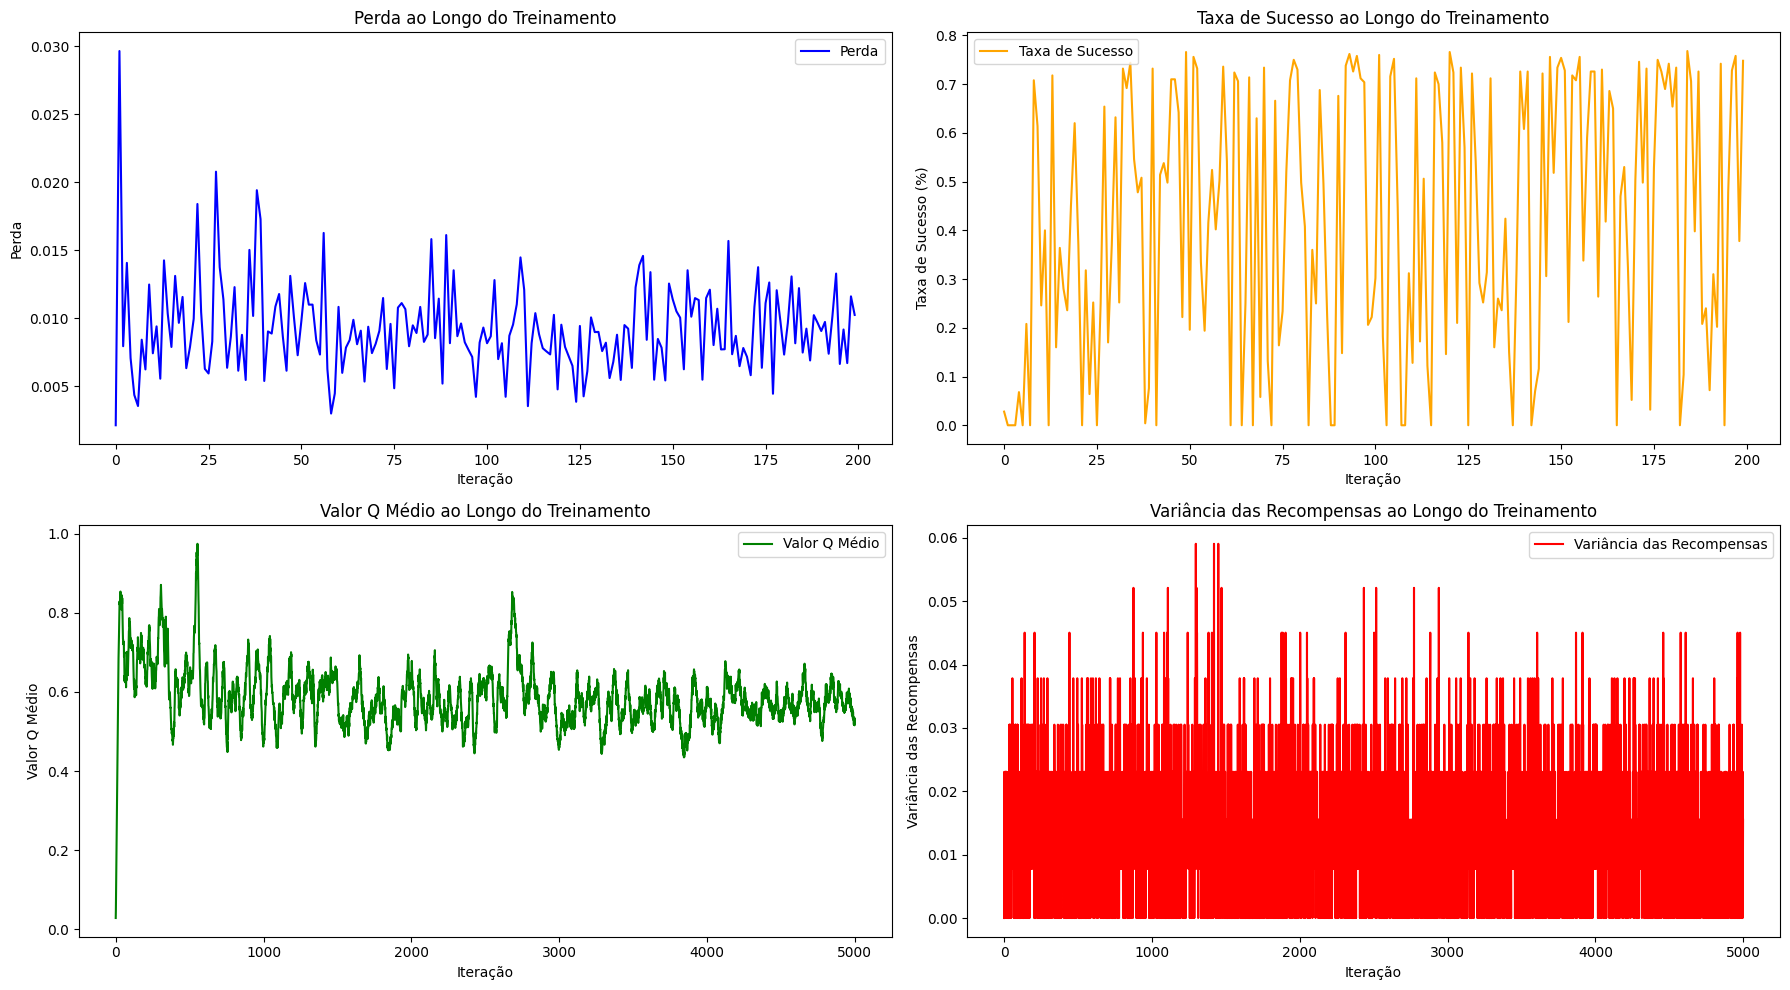

In [12]:
# Visualização Gráfica
plt.figure(figsize=(18, 10))

# Gráfico da Perda
plt.subplot(2, 2, 1)
plt.plot(losses, label="Perda", color="blue")
plt.xlabel("Iteração")
plt.ylabel("Perda")
plt.title("Perda ao Longo do Treinamento")
plt.legend()

# Gráfico da Taxa de Sucesso
plt.subplot(2, 2, 2)
plt.plot(success_rates, label="Taxa de Sucesso", color="orange")
plt.xlabel("Iteração")
plt.ylabel("Taxa de Sucesso (%)")
plt.title("Taxa de Sucesso ao Longo do Treinamento")
plt.legend()

# Gráfico do Valor Q Médio
plt.subplot(2, 2, 3)
plt.plot(q_values_means, label="Valor Q Médio", color="green")
plt.xlabel("Iteração")
plt.ylabel("Valor Q Médio")
plt.title("Valor Q Médio ao Longo do Treinamento")
plt.legend()

# Gráfico da Variância das Recompensas
plt.subplot(2, 2, 4)
plt.plot(rewards_variances, label="Variância das Recompensas", color="red")
plt.xlabel("Iteração")
plt.ylabel("Variância das Recompensas")
plt.title("Variância das Recompensas ao Longo do Treinamento")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Função para extrair a tabela Q da rede neural
def extract_q_table(q_network, num_states, num_actions):
    q_table = np.zeros((num_states, num_actions))
    for state in range(num_states):
        state_tensor = to_one_hot(state, num_states).unsqueeze(0)
        q_values = q_network(state_tensor).detach().numpy()
        q_table[state] = q_values
    return q_table

# Extrair a tabela Q da rede neural treinada
q_table = extract_q_table(q_network, input_dim, output_dim)

# Gravar um vídeo da política treinada
video_path = 'videos/'  # Pasta onde os vídeos serão salvos
video_prefix = 'fqi_FrozenLake'  # Prefixo para o nome do arquivo de vídeo

# Gravar o vídeo
record_video_qtable(ENV_NAME, q_table, episodes=2, folder=video_path, prefix=video_prefix)

# Exibir o vídeo gravado
display_videos_from_path(video_path, prefix=video_prefix)

C:\Users\lucam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Downloads_D\Faculdade\git\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
